등고선 파일 확인

In [ ]:
import geopandas as gpd

file_path = "/home/kbj/Downloads/등고선 5000/N3L_F001.shp"

contours = gpd.read_file(file_path)

print(contours.head())
print(contours.columns)


                                 UFID    DIVI   CONT      SCLS     FMTA  \
0  1000037709008F00110000000000097632  CTD002  490.0  F0017111  2015001   
1  1000037709008F00110000000000097633  CTD002  480.0  F0017111  2015001   
2  1000037709008F00110000000000097635  CTD002  465.0  F0017111  2015001   
3  1000037709008F00110000000000097636  CTD001  475.0  F0017114  2015001   
4  1000037709018F00110000000000097643  CTD002  470.0  F0017111  2015001   

   HEIGHT    SHAPE_LEN                                           geometry  
0   490.0   753.868258  LINESTRING (217531.163 442031.985, 217534.695 ...  
1   480.0  3409.613338  LINESTRING (217619.938 442119.018, 217618.923 ...  
2   465.0  3875.317653  LINESTRING (217619.389 442380.254, 217615.918 ...  
3   475.0  3571.586296  LINESTRING (217619.924 442125.692, 217621.57 4...  
4   470.0  4500.693987  LINESTRING (216061.616 439641.167, 216059.125 ...  
Index(['UFID', 'DIVI', 'CONT', 'SCLS', 'FMTA', 'HEIGHT', 'SHAPE_LEN',
       'geometry'],
   

서울 등고선 컬러 시각화

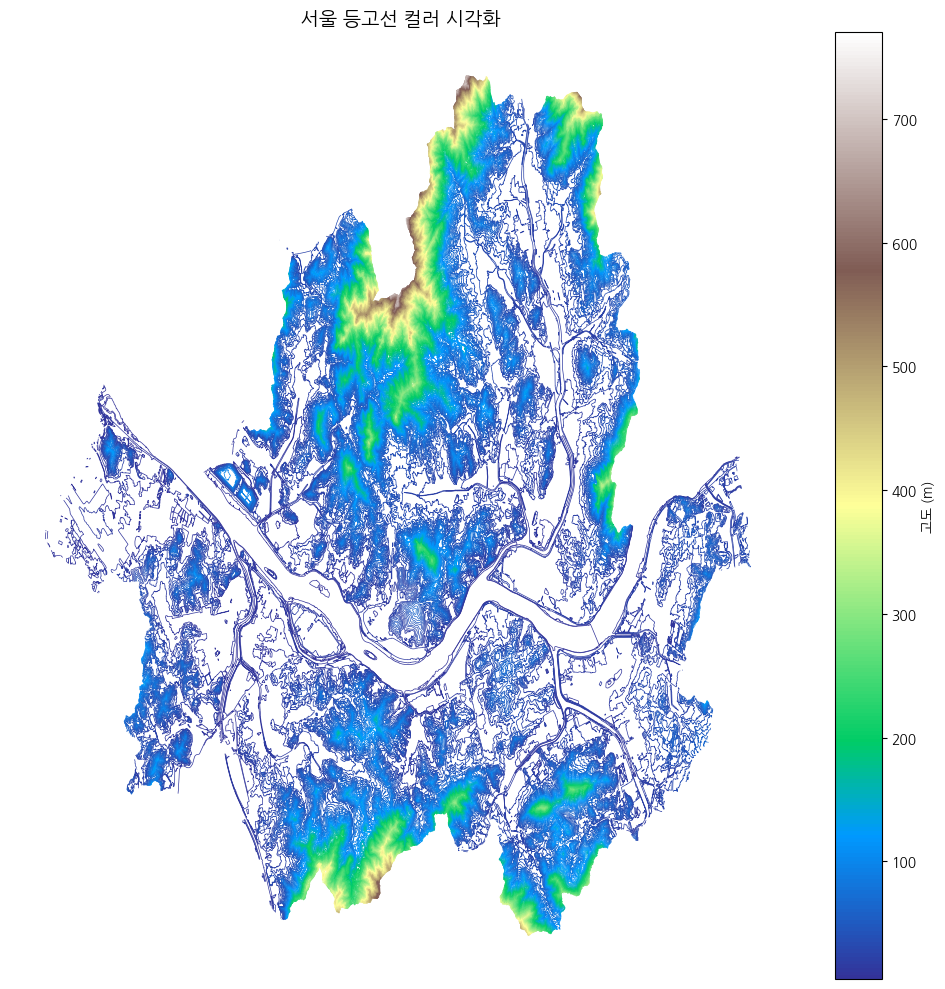

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

gdf = gpd.read_file("/home/kbj/Downloads/등고선 5001/N3L_F001.shp")

lines = []
heights = []

for geom, height in zip(gdf.geometry, gdf['HEIGHT']):
    if geom.geom_type == 'LineString':
        coords = np.array(geom.coords)
        lines.append(coords)
        heights.append(height)
    elif geom.geom_type == 'MultiLineString':
        for part in geom.geoms:
            coords = np.array(part.coords)
            lines.append(coords)
            heights.append(height)

cmap = plt.get_cmap("terrain")
norm = mcolors.Normalize(vmin=min(heights), vmax=max(heights))

fig, ax = plt.subplots(figsize=(10, 10))
line_collection = LineCollection(lines, cmap=cmap, norm=norm, linewidths=0.5)
line_collection.set_array(np.array(heights))

ax.add_collection(line_collection)
ax.autoscale()
ax.set_title(" 서울 등고선 컬러 시각화", fontsize=14)
ax.axis("off")

cbar = plt.colorbar(line_collection, ax=ax)
cbar.set_label("고도 (m)")

plt.tight_layout()
plt.show()

서울 표고점 시각화

/tmp/ipykernel_29358/3044829568.py:34: UserWarning: Glyph 9968 (\N{MOUNTAIN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/kbj/venv/eda_venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9968 (\N{MOUNTAIN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


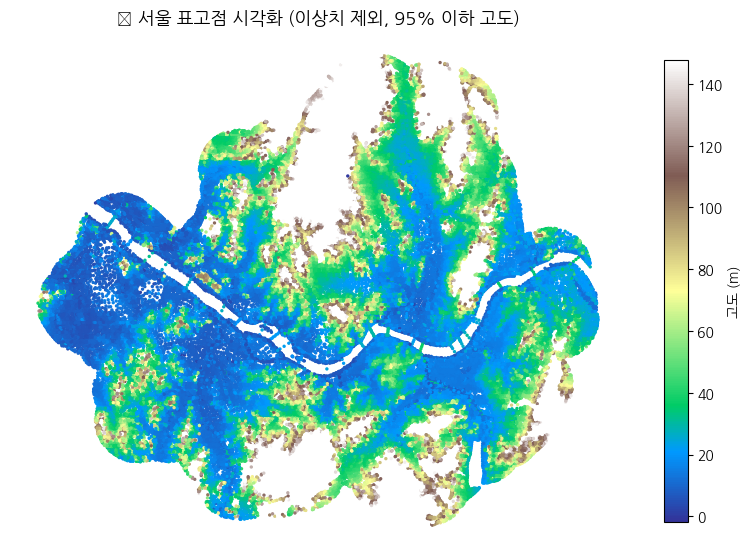

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np

file_path = "/home/kbj/Downloads/표고 5000/N3P_F002.shp"
gdf = gpd.read_file(file_path)

height_col = "HEIGHT"

vmin = gdf[height_col].min()
vmax = np.percentile(gdf[height_col], 95)

cmap = plt.get_cmap("terrain")
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(
    ax=ax,
    column=height_col,
    cmap=cmap,
    norm=norm,
    markersize=2,
    legend=True,
    legend_kwds={'label': "고도 (m)", 'shrink': 0.6}
)

ax.set_title(" 서울 표고점 시각화 (이상치 제외, 95% 이하 고도)", fontsize=13)
ax.axis("off")
plt.tight_layout()
plt.show()


등고선과 자치구 경계파일을 이용해 자치구별 평균고도 계산

In [ ]:
from pyproj import CRS

contour_path = "/home/kbj/Downloads/등고선 5001/N3L_F001.shp"
gdf_contour = gpd.read_file(contour_path)

gu_path = "/home/kbj/Downloads/shx/LARD_ADM_SECT_SGG_11_202502.shp"  # 실제 자치구 shp 경로
gdf_gu = gpd.read_file(gu_path, encoding="cp949") 

if gdf_gu.crs is None:
    gdf_gu.set_crs(CRS.from_epsg(5179), inplace=True)  # TM 중부, 서울 기준

if gdf_contour.crs != gdf_gu.crs:
    gdf_contour = gdf_contour.to_crs(gdf_gu.crs)

joined = gpd.sjoin(gdf_contour, gdf_gu, how="inner", predicate="intersects")

print(" 컬럼 목록:", joined.columns)

avg_height_by_gu = joined.groupby("SGG_NM")["HEIGHT"].mean().reset_index()
avg_height_by_gu.columns = ["자치구", "평균고도"]

print(avg_height_by_gu.sort_values("평균고도", ascending=False))


📌 컬럼 목록: Index(['UFID', 'DIVI', 'CONT', 'SCLS', 'FMTA', 'HEIGHT', 'SHAPE_LEN',
       'geometry', 'index_right', 'ADM_SECT_C', 'SGG_NM', 'SGG_OID',
       'COL_ADM_SE'],
      dtype='object')
     자치구        평균고도
9    도봉구  354.339623
2    강북구  302.902468
22   종로구  298.912711
4    관악구  253.101266
16   성북구  215.446571
8    노원구  206.645833
21   은평구  167.675000
7    금천구  155.443038
13  서대문구  131.588235
14   서초구  129.952077
24   중랑구  128.592593
5    광진구  119.758454
23    중구   96.170635
0    강남구   75.738523
20   용산구   73.842593
11   동작구   73.405797
6    구로구   56.452703
15   성동구   55.146341
10  동대문구   51.229508
18   양천구   50.441176
12   마포구   46.401674
1    강동구   44.040698
17   송파구   35.131195
3    강서구   32.735369
19  영등포구   13.843537


서울시 자치구별 평균 고도 시각화

/tmp/ipykernel_24206/3566872327.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="평균고도", y="자치구", palette="terrain")


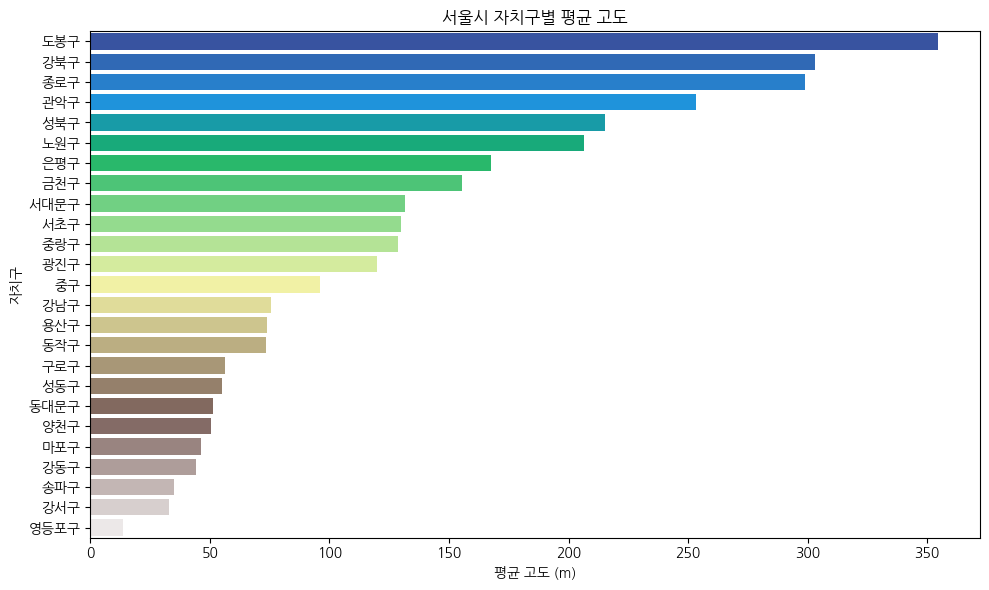

In [ ]:
import seaborn as sns
import koreanize_matplotlib 

plot_df = avg_height_by_gu.sort_values("평균고도", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="평균고도", y="자치구", palette="terrain")

plt.title("서울시 자치구별 평균 고도")
plt.xlabel("평균 고도 (m)")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()


자치구별 평균 고도 vs 따릉이 대여 수 (상관관계 시각화)

/tmp/ipykernel_29358/1470827800.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_height = pd.read_sql(query1, conn)
/tmp/ipykernel_29358/1470827800.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rentals = pd.read_sql(query2, conn)


📊 상관계수(Pearson): -0.5086


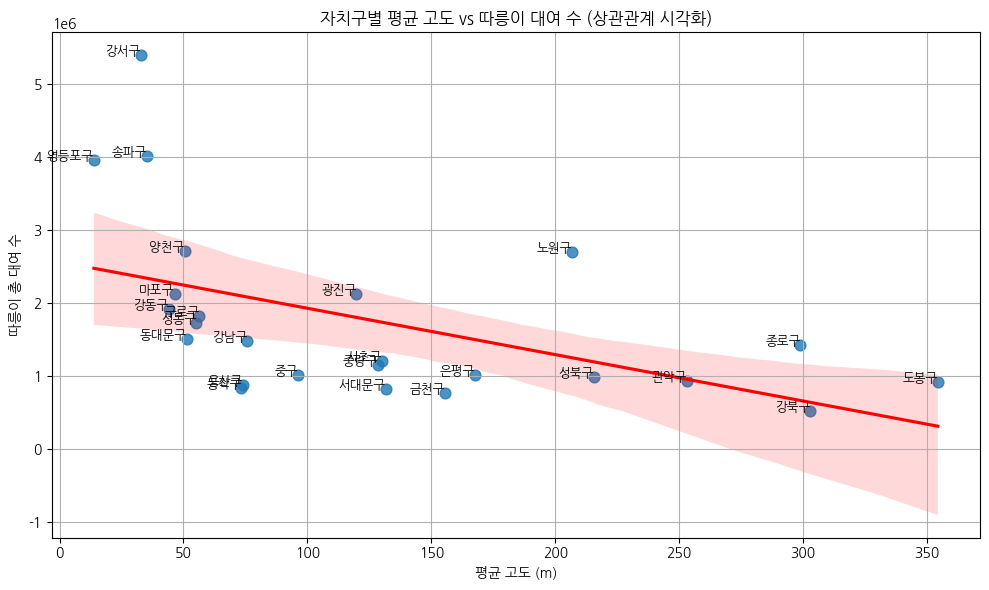

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

query1 = "SELECT gu_name, avg_height FROM avg_height_by_gu"
df_height = pd.read_sql(query1, conn)

query2 = """
    SELECT station_gu AS gu_name, SUM(rental_count) AS total_rentals
    FROM rental_hourly_gu_summary
    GROUP BY station_gu
"""
df_rentals = pd.read_sql(query2, conn)

conn.close()

df = pd.merge(df_height, df_rentals, on="gu_name")


corr = df['avg_height'].corr(df['total_rentals'])
print(f" 상관계수(Pearson): {corr:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="avg_height", y="total_rentals",
            scatter_kws={"s": 60, "alpha": 0.8},
            line_kws={"color": "red"})

for i in range(len(df)):
    plt.text(df["avg_height"][i], df["total_rentals"][i], df["gu_name"][i], fontsize=9, ha='right')

plt.title("자치구별 평균 고도 vs 따릉이 대여 수 (상관관계 시각화)")
plt.xlabel("평균 고도 (m)")
plt.ylabel("따릉이 총 대여 수")
plt.grid(True)
plt.tight_layout()
plt.show()